# **IDL Assignment 1 - MLP on MNIST Dataset**

## **Assigning Tensorflow version and importing the libraries required for the tasks**


In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
tf.__version__

'2.2.0-rc3'

## **Initialising file upload and mounting drive**

In [3]:
from google.colab import files
files.upload()

Saving datasets.py to datasets.py


{'datasets.py': b'import numpy as np\n\n\nclass MNISTDataset:\n    """\'Bare minimum\' class to wrap MNIST numpy arrays into a dataset."""\n    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,\n                 to01=True, shuffle=True, seed=None):\n        """\n        Use seed optionally to always get the same shuffling (-> reproducible\n        results).\n        """\n        self.batch_size = batch_size\n        self.train_data = train_imgs\n        self.train_labels = train_lbs.astype(np.int32)\n        self.test_data = test_imgs\n        self.test_labels = test_lbls.astype(np.int32)\n\n        if to01:\n            # int in [0, 255] -> float in [0, 1]\n            self.train_data = self.train_data.astype(np.float32) / 255\n            self.test_data = self.test_data.astype(np.float32) / 255\n\n        self.size = self.train_data.shape[0]\n\n        if seed:\n            np.random.seed(seed)\n        if shuffle:\n            self.shuffle_train()\n        

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Importing datasets**

In [ ]:
from datasets import MNISTDataset

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

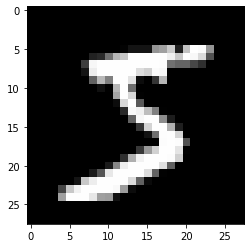

In [5]:
plt.imshow(train_images[0], cmap="Greys_r")


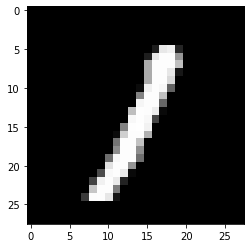

In [6]:
plt.imshow(train_images[455], cmap="Greys_r")


In [7]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
mnist_data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

## **MNIST Multi Layer Perceptron**

### **Hidden Layer = 2**

**Observations made**



*   Hidden layers - 2 | No of neurons in hidden layers - 16,8 | Activation Function - RelU, ReLU, Softmax | Acc(Tr,Test) = 89.84,87.03
*   Hidden layers - 2 | No of neurons in hidden layers - 112,112 | Activation Function - RelU, ReLU, Softmax | Acc(Tr,Test) = 18.75,11.36
*   Hidden layers - 2 | No of neurons in hidden layers - 112,16 | Activation Function - RelU, ReLU, Softmax | Acc(Tr,Test) = 92.9,93.2
*   Hidden layers - 2 | No of neurons in hidden layers - 112,32 | Activation Function - RelU, ReLU, Softmax | Acc(Tr,Test) = 91.4,93.6
*   Hidden layers - 2 | No of neurons in hidden layers - 112,64 | Activation Function - RelU, ReLU, Softmax | Acc(Tr,Test) = 94.5,93.68


In [ ]:
## Define Hyper parameters
input_neurons = 784
hidden1_neurons = 112
hidden2_neurons = 64
output_neurons = 10

train_steps = 1000
learning_rate = 0.1

In [ ]:
## Initialising initial weights and biases

# hidden layer1
w1 = tf.Variable(tf.random.uniform([input_neurons,hidden1_neurons], minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(tf.zeros([hidden1_neurons]))


# hidden layer2
w2 = tf.Variable(tf.random.uniform([hidden1_neurons,hidden2_neurons], minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b2 = tf.Variable(tf.zeros([hidden2_neurons]))


# output layer
w3 = tf.Variable(tf.random.uniform([hidden2_neurons,output_neurons], minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b3 = tf.Variable(tf.zeros([output_neurons]))

#### **MLP for 2 layer network**

The code runs the neural network defined on the defined layers and updates the corresponding weights and biases. It then prints the accuracy and losses after every 100 iteration. 


In [24]:
train_accuracy_list = []
steps_list = []
loss_list = []

for step in range(train_steps):
    img_batch, lbl_batch = mnist_data.next_batch()
    with tf.GradientTape(persistent=True) as tape:

        # The piece of code does the output of the hidden layers and output layer with its corresponding activation function
        h1 = tf.nn.relu(tf.matmul(img_batch, w1) + b1)
        h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
        logits= tf.matmul(h2, w3) + b3


        # The piece of code calculates the loss obtained at the output layer
        loss_output = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=lbl_batch))
        

        
    ## Gradient functionality is done using "tape"    
    grads = tape.gradient(loss_output, [w1, b1, w2, b2, w3, b3])

    w1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])

    w2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])

    w3.assign_sub(learning_rate * grads[4])
    b3.assign_sub(learning_rate * grads[5])
    
    # Print the accuracy and losses after every 100 iteration
    if not step % 100:
        train_preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        train_acc = tf.reduce_mean(tf.cast(tf.equal(train_preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(loss_output, train_acc))
        train_accuracy_list.append(train_acc)
        loss_list.append(loss_output)
        steps_list.append(step)

Loss: 2.302222967147827 Accuracy: 0.0625
Loss: 0.8137916326522827 Accuracy: 0.7265625
Loss: 0.4607875347137451 Accuracy: 0.859375
Loss: 0.4025427997112274 Accuracy: 0.890625
Starting new epoch...
Loss: 0.2710282802581787 Accuracy: 0.9453125
Loss: 0.2368943691253662 Accuracy: 0.921875
Loss: 0.24981030821800232 Accuracy: 0.9375
Loss: 0.2642776370048523 Accuracy: 0.921875
Loss: 0.2522876560688019 Accuracy: 0.9375
Starting new epoch...
Loss: 0.19959567487239838 Accuracy: 0.9453125


#### **Plots**

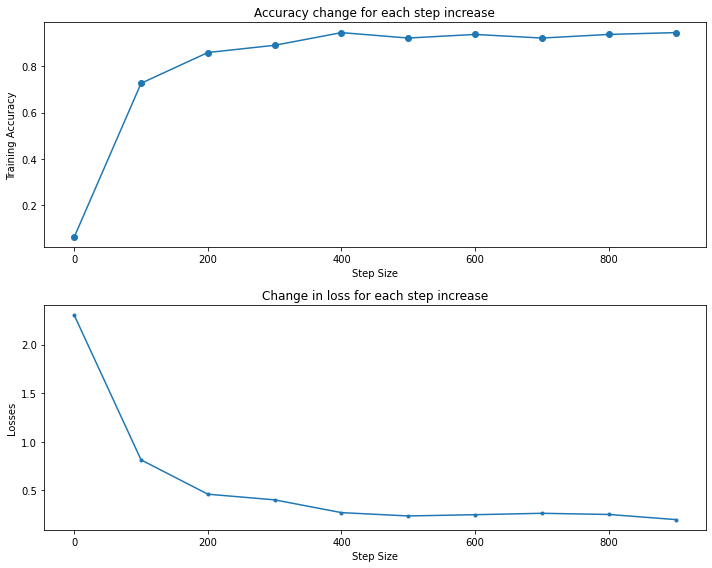

In [25]:
plt.figure(figsize=(10,8))

plt.subplot(2,1, 1)
plt.plot(steps_list,train_accuracy_list,'o-')
plt.ylabel('Training Accuracy')
plt.xlabel('Step Size')
plt.title('Accuracy change for each step increase')

plt.subplot(2, 1, 2)
plt.plot(steps_list,loss_list,".-")
plt.ylabel('Losses')
plt.xlabel('Step Size')
plt.title('Change in loss for each step increase')

plt.tight_layout()
plt.show()

#### **Testing of the network**

Pass the testing data to calculate the test accuracy. 

In [26]:
test_pred_h1 = tf.nn.relu(tf.matmul(mnist_data.test_data, w1) + b1)  
test_pred_h2 = tf.nn.relu(tf.matmul(test_pred_h1, w2) + b2) 
test_preds = tf.argmax(tf.matmul(test_pred_h2, w3) + b3, axis=1,
                       output_type=tf.int32)
test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist_data.test_labels),
                             tf.float64))

print("Accuracy: {}".format(test_acc))

Accuracy: 0.9368


### **Hidden Layer = 1**

**Observations made**



*   Hidden layers - 1 | No of neurons in hidden layers - 16 | Activation Function - RelU, Softmax | Acc(Tr,Test) = 86.71,91.28
*   Hidden layers - 1 | No of neurons in hidden layers - 112 | Activation Function - RelU, Softmax | Acc(Tr,Test) = 94.53,93.05
*   Hidden layers - 1 | No of neurons in hidden layers - 64 | Activation Function - RelU, Softmax | Acc(Tr,Test) = 90.62,93.07
*   Hidden layers - 1 | No of neurons in hidden layers - 32 | Activation Function - RelU, Softmax | Acc(Tr,Test) = 93.7,92.3

In [ ]:
 ## Define Hyper parameters
input_neurons = 784
hidden1_neurons = 112
output_neurons = 10

train_steps = 1000
learning_rate = 0.1

In [ ]:
# hidden layer1
w1 = tf.Variable(tf.random.uniform([input_neurons,hidden1_neurons], minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(tf.zeros([hidden1_neurons]))


# output layer
w3 = tf.Variable(tf.random.uniform([hidden1_neurons,output_neurons], minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b3 = tf.Variable(tf.zeros([output_neurons]))

In [ ]:
## The function MLP defines the output of the hidden layers and output layer with its corresponding activation function

def mlp(x):
    # hidden layer1
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)


    # output layer
    logits= tf.matmul(h1, w3) + b3
    
    return logits

In [42]:
train_accuracy_list_2 = []
steps_list_2 = []
loss_list_2 = []

for step in range(train_steps):
    img_batch, lbl_batch = mnist_data.next_batch()
    with tf.GradientTape(persistent=True) as tape:
        logits = mlp(img_batch)
        loss_output = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=lbl_batch))
        #loss_h1 = tf.multiply(w3,loss_output)
        
    #paramater_update(tape,loss_output,loss_h1,learning_rate)
    
    #Gradient calculation
    grads = tape.gradient(loss_output, [w1, b1, w3, b3])

    #hidden layer1
    w1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])

    # output layer
    w3.assign_sub(learning_rate * grads[2])
    b3.assign_sub(learning_rate * grads[3])


    if not step % 100:
        train_preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        train_acc = tf.reduce_mean(tf.cast(tf.equal(train_preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(loss_output, train_acc))
        train_accuracy_list_2.append(train_acc)
        loss_list_2.append(loss_output)
        steps_list_2.append(step)

Loss: 2.3092432022094727 Accuracy: 0.171875
Loss: 0.42835962772369385 Accuracy: 0.9140625
Starting new epoch...
Loss: 0.35702139139175415 Accuracy: 0.90625
Loss: 0.32660362124443054 Accuracy: 0.90625
Loss: 0.2711184024810791 Accuracy: 0.890625
Loss: 0.41941317915916443 Accuracy: 0.828125
Loss: 0.29222214221954346 Accuracy: 0.875
Starting new epoch...
Loss: 0.239985853433609 Accuracy: 0.9375
Loss: 0.24576625227928162 Accuracy: 0.8984375
Loss: 0.18738529086112976 Accuracy: 0.9453125


#### **Plots**

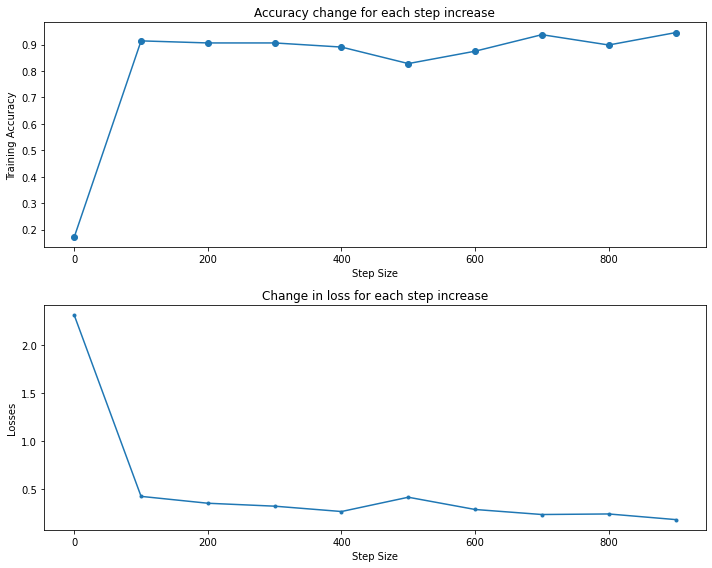

In [43]:
plt.figure(figsize=(10,8))


plt.subplot(2,1, 1)
plt.plot(steps_list_2,train_accuracy_list_2,'o-')
plt.ylabel('Training Accuracy')
plt.xlabel('Step Size')
plt.title('Accuracy change for each step increase')

plt.subplot(2, 1, 2)
plt.plot(steps_list_2,loss_list_2,".-")
plt.ylabel('Losses')
plt.xlabel('Step Size')
plt.title('Change in loss for each step increase')

plt.tight_layout()
plt.show()

#### **Testing of network with 1 hidden layer**

In [44]:
test_pred_h1 = tf.nn.relu(tf.matmul(mnist_data.test_data, w1) + b1)  
test_preds = tf.argmax(tf.matmul(test_pred_h1, w3) + b3, axis=1,
                       output_type=tf.int32)
test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist_data.test_labels),
                             tf.float64))

print("Accuracy: {}".format(test_acc))

Accuracy: 0.9305
